In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import os

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
dataset_path = '/content/drive/MyDrive/archive (2)/brain_tumor_dataset'

In [ ]:
folders = os.listdir(dataset_path)
print(folders)

['yes', 'no', 'test']


In [ ]:
subdirs = os.listdir(dataset_path)[:2]
for subdir in subdirs:
    print(f"{subdir} contains {len(os.listdir(dataset_path+'/'+subdir))} images")


yes contains 155 images
no contains 98 images


In [ ]:
def load_images(folder):
    imgs = []
    target = 0
    labels = []
    for i in os.listdir(folder):
        subdir = os.path.join(folder, i)
        for j in os.listdir(subdir):
            img_dir = os.path.join(subdir,j)
            try:
                img = cv2.imread(img_dir)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (128,128))
                imgs.append(img)
                labels.append(target)
            except:
                continue
        target += 1

    imgs = np.array(imgs)
    labels = np.array(labels)

    return imgs, labels

In [ ]:
data, labels = load_images(dataset_path)
data.shape, labels.shape

((254, 128, 128), (254,))

In [ ]:
norm_data = data / 255.
norm_data = np.expand_dims(norm_data, axis=3)
norm_data.shape, norm_data[0]

((254, 128, 128, 1),
 array([[[0.01176471],
         [0.01176471],
         [0.01176471],
         ...,
         [0.00784314],
         [0.00784314],
         [0.00784314]],
 
        [[0.01176471],
         [0.01176471],
         [0.01176471],
         ...,
         [0.00784314],
         [0.00784314],
         [0.00784314]],
 
        [[0.01176471],
         [0.01176471],
         [0.01176471],
         ...,
         [0.00784314],
         [0.00784314],
         [0.00784314]],
 
        ...,
 
        [[0.00784314],
         [0.00784314],
         [0.00784314],
         ...,
         [0.00784314],
         [0.00784314],
         [0.01176471]],
 
        [[0.00784314],
         [0.00784314],
         [0.00784314],
         ...,
         [0.00784314],
         [0.00784314],
         [0.01176471]],
 
        [[0.00784314],
         [0.00784314],
         [0.00784314],
         ...,
         [0.00392157],
         [0.00392157],
         [0.00784314]]]))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(norm_data, labels, test_size=0.2, random_state=42)


In [ ]:
tf.random.set_seed(21)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64,
                           kernel_size=3,
                           activation='relu',
                           input_shape=(128,128,1)),
    tf.keras.layers.Conv2D(32,3,activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2,
                              padding='valid'),
    tf.keras.layers.Conv2D(32,3,activation='relu'),
    tf.keras.layers.Conv2D(16,3,activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)


Epoch 1/50
6/6 [==============================] - 2s 99ms/step - loss: 0.6670 - accuracy: 0.6420 - val_loss: 0.6397 - val_accuracy: 0.5854
Epoch 2/50
6/6 [==============================] - 0s 37ms/step - loss: 0.6019 - accuracy: 0.6420 - val_loss: 0.6058 - val_accuracy: 0.5854
Epoch 3/50
6/6 [==============================] - 0s 36ms/step - loss: 0.5797 - accuracy: 0.6914 - val_loss: 0.5353 - val_accuracy: 0.8049
Epoch 4/50
6/6 [==============================] - 0s 35ms/step - loss: 0.5337 - accuracy: 0.7716 - val_loss: 0.4844 - val_accuracy: 0.8049
Epoch 5/50
6/6 [==============================] - 0s 35ms/step - loss: 0.5177 - accuracy: 0.7654 - val_loss: 0.4752 - val_accuracy: 0.8537
Epoch 6/50
6/6 [==============================] - 0s 34ms/step - loss: 0.5148 - accuracy: 0.7716 - val_loss: 0.5265 - val_accuracy: 0.8780
Epoch 7/50
6/6 [==============================] - 0s 34ms/step - loss: 0.5212 - accuracy: 0.7840 - val_loss: 0.4992 - val_accuracy: 0.8537
Epoch 8/50
6/6 [===========

This one for svm

In [ ]:
cnn_features = model.predict(X_train)


7/7 [==============================] - 1s 23ms/step


In [ ]:
cnn_features = cnn_features.reshape(cnn_features.shape[0], -1)

In [ ]:
# SVM Model
svm_model = SVC(kernel='linear')
svm_model.fit(cnn_features, y_train)

SVC(kernel='linear')

In [ ]:
# Extract features from the test data
cnn_features_test = model.predict(X_test)
cnn_features_test = cnn_features_test.reshape(cnn_features_test.shape[0], -1)


2/2 [==============================] - 0s 17ms/step


In [ ]:
# Evaluate the SVM model
svm_preds = svm_model.predict(cnn_features_test)
svm_acc = np.sum(svm_preds == y_test) / len(y_test) * 100
print(f"Accuracy of SVM on Test Data: {svm_acc:.2f}%")

Accuracy of SVM on Test Data: 84.31%


In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, svm_preds)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[26  1]
 [ 7 17]]


In [ ]:
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

2/2 [==============================] - 0s 11ms/step
Confusion Matrix:
[[26  1]
 [ 7 17]]


NameError: ignored

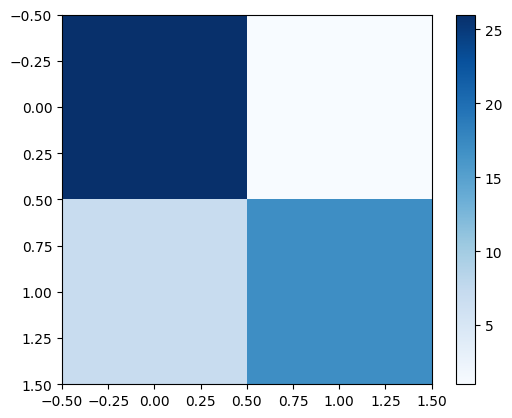

In [ ]:
svm_pred = model.predict(X_test)
svm_pred = np.round(svm_pred).astype(int)
svm_pred = np.squeeze(svm_pred)

# Compute confusion matrix
cm = confusion_matrix(y_test, svm_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(label_mapping))
plt.xticks(tick_marks, label_mapping.keys())
plt.yticks(tick_marks, label_mapping.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

This is for the knn

In [ ]:
result_cnn = model.evaluate(X_test, y_test, verbose=0)
print(f"Accuracy on Evaluation (SVM and CNN): {result_cnn[1]*100:.2f}%\nLoss: {result_cnn[0]:.4f}")


Accuracy on Evaluation (SVM and CNN): 84.31%
Loss: 1.4979


In [ ]:
# Flatten the data for KNN
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [ ]:
# Train and evaluate KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_flat, y_train)

KNeighborsClassifier()

In [ ]:
y_pred_knn = knn.predict(X_test_flat)
acc_knn = np.mean(y_pred_knn == y_test)
print(f"Accuracy on Evaluation (CNN AND KNN): {acc_knn*100:.2f}%")

Accuracy on Evaluation (CNN AND KNN): 80.39%


In [ ]:

y_pred_cnn = model.predict(X_test)
y_pred_cnn = (y_pred_cnn > 0.5).astype(int)  # Convert predicted probabilities to binary labels (0 or 1)

2/2 [==============================] - 0s 10ms/step


In [ ]:
y_pred_cnn

array([[1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1]])

In [ ]:
# Get predictions
predictions = model.predict(norm_data)
y_pred = np.round(predictions).flatten().astype(int)

# Compute confusion matrix
cm = confusion_matrix(labels, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)


8/8 [==============================] - 0s 18ms/step
Confusion Matrix:
[[154   1   0]
 [ 11  87   0]
 [  1   0   0]]


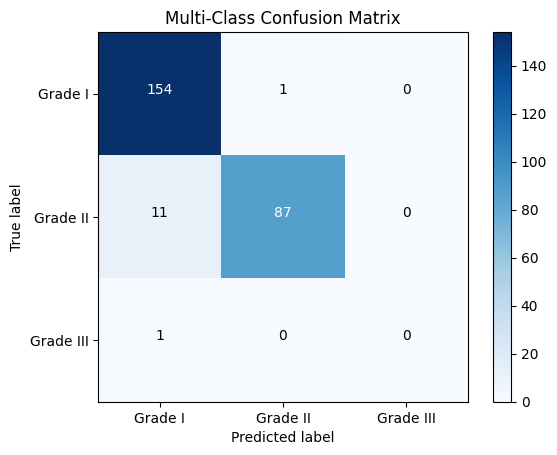

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Confusion matrix values
cm_multiclass = np.array([[154, 1, 0],
                          [11, 87, 0],
                          [1, 0, 0]])

# Define multi-class labels
multiclass_classes = ['Grade I', 'Grade II', 'Grade III']

# Plot multi-class confusion matrix
plt.imshow(cm_multiclass, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Multi-Class Confusion Matrix')
plt.colorbar()

# Add labels to the multi-class confusion matrix plot
tick_marks_multiclass = np.arange(len(multiclass_classes))
plt.xticks(tick_marks_multiclass, multiclass_classes)
plt.yticks(tick_marks_multiclass, multiclass_classes)

thresh_multiclass = cm_multiclass.max() / 2.0
for i in range(cm_multiclass.shape[0]):
    for j in range(cm_multiclass.shape[1]):
        plt.text(j, i, format(cm_multiclass[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_multiclass[i, j] > thresh_multiclass else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()
